In [209]:
import numpy as np
from hamiltonians import *
from helpers import *
from qite_params import QITE_params

In [228]:
import time

def get_term_matrix(H, term):
    return Hamiltonian([H.hm_list[term]], H.d, H.l).get_matrix()

TOLERANCE = 1e-8

def exp_mat_psi(mat, psi):
    chi = psi.copy()
    phi = psi.copy()
    i = 1
    while np.linalg.norm(chi) > TOLERANCE:
        chi = db/i * (mat @ chi)
        phi += chi
        i += 1
    return phi

def get_delta0(term, psi):
    delta0 = exp_mat_psi( get_term_matrix(H, term), psi )
    c = np.linalg.norm(delta0)
    delta0 /= c
    
    delta0 -= psi
    delta0 /= db
    
    return delta0, c

def update_alist(params, psi, alist, term):
    nactive = len(hm_list[term][2])
    nops = 4**nactive
    S = np.zeros((nops, nops), dtype=complex)
    b = np.zeros(nops, dtype=float)
    norm = 1
    
    for i in range(nops):
        # Calculate S[i,:] terms
        for j in range(0,i,1):
            p_, c_ = pauli_string_prod(i, j, nactive)
            pstring = int_to_base(p_, 4, nactive)
            P = sigma_matrices[pstring[0]]
            for k in range(1,nactive):
                P = np.kron(pstring[k], P) # Rightmost term is index 0
            
            S[i,j] = np.vdot(psi, P @ psi) * c_
            S[j,i] = S[i,j].conjugate()
        S[i,i] = 1.0
        
        # Calculate b[i]
        istring = int_to_base(i, 4, nactive)
        I = sigma_matrices[istring[0]]
        for k in range(1,nactive):
            I = np.kron(sigma_matrices[istring[k]], I)
        
        delta0, c = get_delta0(term, psi)
        b[i] = 2*np.real(np.vdot(delta0, I @ psi))
        norm *= c
    
    a = np.linalg.lstsq(np.real(S).astype(float), b, rcond=-1)[0]
    alist.append(a)
    
    return S, b, norm

def qite_step(params, psi0):
    psi = psi0.copy()
    alist = []
    S_list = []
    b_list = []
    norm = 1
    for i in range(H.num_terms):
        S, b, c = update_alist(params, psi, alist, i)
        S_list.append(S)
        b_list.append(b)
        norm *= c
        a = alist[i]
        nactive = len(H.hm_list[i][2])
        nops = len(a)
        A = np.zeros((2**nactive, 2**nactive), dtype=complex)
        for i in range(nops):
            istring = int_to_base(i, 4, nactive)
            I = sigma_matrices[istring[0]]
            for k in range(1,nactive):
                I = np.kron(sigma_matrices[istring[k]], I)
            A += a[i] * I
        
        psi = exp_mat_psi( -1j*A*db , psi )
    
    return psi, alist, S_list, b_list, norm

In [230]:
psi, al, sl, bl, c = qite_step(params, psi0)

np.real(sl[0])@al[0] - bl[0]

array([ 2.22044605e-16, -2.22044605e-16,  0.00000000e+00,  2.22044605e-16])

In [231]:
hm_list = [
    [ [1], [1.0], [0] ]
]
d = 1
l = 1
H = Hamiltonian(hm_list, d, l)
H_mat = H.get_matrix()
print(H_mat)

db = 0.1
delta = 0.0
N = 20
D = 0
nbits = H.nbits

psi0 = np.array([1,0], dtype=complex)

params = QITE_params(H)
params.load_hamiltonian_params(D, False)
params.set_run_params(db, delta, N, None, None, init_sv = psi0)

svs = np.zeros((N+1, 2**nbits), dtype=complex)
alist = []
S_list = []
b_list = []
c_list = []
svs[0] = psi0

for i in range(1, N+1):
    print('Iteration {}...'.format(i),end=' ', flush=True)
    t0 = time.time()
    
    psi, n_a, n_S, n_b, c = qite_step(params, svs[i-1])
    svs[i] = psi
    alist += n_a
    S_list += n_S
    b_list += n_b
    c_list.append(c)
    
    t1 = time.time()
    duration = t1 - t0
    print('Done -- Iteration time = {:0.2f} {}'.format(duration if duration < 60 else duration/60, 'seconds' if duration < 60 else 'minutes'))

[[0.+0.j 1.+0.j]
 [1.+0.j 0.+0.j]]
Performing Hamiltonian precalculations...
	Calculating Unitary Domains... Done
	Calculating Required Pauli Measurements... Done
Iteration 1... Done -- Iteration time = 0.00 seconds
Iteration 2... Done -- Iteration time = 0.00 seconds
Iteration 3... Done -- Iteration time = 0.00 seconds
Iteration 4... Done -- Iteration time = 0.00 seconds
Iteration 5... Done -- Iteration time = 0.00 seconds
Iteration 6... Done -- Iteration time = 0.00 seconds
Iteration 7... Done -- Iteration time = 0.00 seconds
Iteration 8... Done -- Iteration time = 0.00 seconds
Iteration 9... Done -- Iteration time = 0.00 seconds
Iteration 10... Done -- Iteration time = 0.00 seconds
Iteration 11... Done -- Iteration time = 0.00 seconds
Iteration 12... Done -- Iteration time = 0.00 seconds
Iteration 13... Done -- Iteration time = 0.00 seconds
Iteration 14... Done -- Iteration time = 0.00 seconds
Iteration 15... Done -- Iteration time = 0.00 seconds
Iteration 16... Done -- Iteration ti

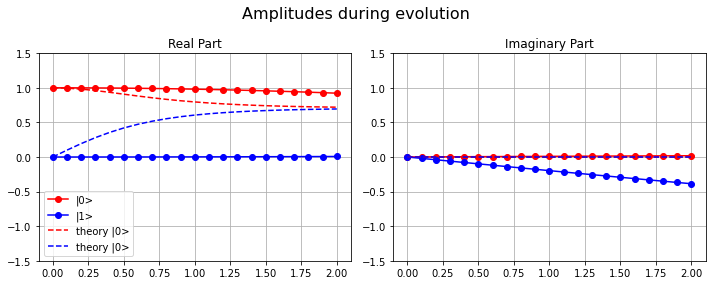

In [232]:
def foo(M, t):
    w,V = np.linalg.eig(M)
    e = V @ np.diag(np.exp(w*t)) @ np.linalg.inv(V)
    phi = e[:,0]
    return phi/np.linalg.norm(phi)

import matplotlib.pyplot as plt
f = plt.figure(figsize=(10,4))
axs = [f.add_subplot(121), f.add_subplot(122)]
t = np.arange(0,N+1,1)*db
re = np.real(svs)
im = np.imag(svs)

theory = np.zeros( (N+1,2), dtype=complex )
for i in range(N+1):
    theory[i,:] = foo(H.get_matrix(), i*db)

axs[0].plot(t,re[:,0],'ro-', label='|0>')
axs[0].plot(t,re[:,1],'bo-', label='|1>')

axs[0].plot(t, np.real(theory[:,0]), 'r--', label='theory |0>' )
axs[0].plot(t, np.real(theory[:,1]), 'b--', label='theory |0>' )

# axs[0].plot(t, csh, 'r--', label='theory')

# axs[0].axhline(y=np.sqrt(0.5))
# axs[0].axhline(y=-np.sqrt(0.5))

# axs[0].plot(t,np.cos(f_*t)*np.sqrt(0.5), 'r--', label='cos(ft)')
# axs[0].plot(t,-np.sin(2*f_*t), 'b--', label='-sin(2ft)')
# axs[0].plot(t,np.cos(2*f_*t), 'g--', label='cos(2ft)')
axs[1].plot(t,im[:,0],'ro-', label='|0>')
axs[1].plot(t,im[:,1],'bo-', label='|1>')

axs[1].plot(t, np.imag(theory[:,0]), 'r--', label='theory |0>' )
axs[1].plot(t, np.imag(theory[:,1]), 'b--', label='theory |0>' )

# axs[1].plot(t, snh, 'b--', label='theory')

# axs[1].plot(t,np.sin(f_*t), 'b--', label='sin(ft)')
# axs[1].plot(t,np.sin(2*f_*t), 'g--', label='sin(2ft)')

axs[0].set_ylim(-1.5,1.5)
axs[1].set_ylim(-1.5,1.5)

axs[0].title.set_text('Real Part')
axs[1].title.set_text('Imaginary Part')


axs[0].legend(loc='best')
# axs[1].legend(loc='best')

axs[0].grid()
axs[1].grid()

f.suptitle('Amplitudes during evolution', fontsize=16)
f.tight_layout()
plt.show()

In [225]:
svs

array([[1.        +0.j        , 0.        +0.j        ],
       [0.99999988+0.00049302j, 0.        +0.j        ],
       [0.99999966+0.00082578j, 0.        +0.j        ],
       [0.99999917+0.00128761j, 0.        +0.j        ],
       [0.9999984 +0.00179015j, 0.        +0.j        ],
       [0.99999747+0.00225147j, 0.        +0.j        ],
       [0.99999626+0.00273661j, 0.        +0.j        ],
       [0.9999947 +0.00325532j, 0.        +0.j        ],
       [0.99999292+0.00376302j, 0.        +0.j        ],
       [0.99999094+0.0042559j , 0.        +0.j        ],
       [0.99998879+0.00473515j, 0.        +0.j        ],
       [0.99998633+0.00522907j, 0.        +0.j        ],
       [0.99998371+0.00570864j, 0.        +0.j        ],
       [0.99998078+0.00620063j, 0.        +0.j        ],
       [0.99997751+0.00670658j, 0.        +0.j        ],
       [0.99997406+0.00720262j, 0.        +0.j        ],
       [0.99997045+0.0076882j , 0.        +0.j        ],
       [0.9999665 +0.00818469j,

In [217]:
S_list

[array([[1.+0.j, 0.-0.j, 0.-0.j, 1.-0.j],
        [0.+0.j, 1.+0.j, 0.+1.j, 0.-0.j],
        [0.+0.j, 0.-1.j, 1.+0.j, 0.-0.j],
        [1.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]]),
 array([[1.+0.j, 0.-0.j, 0.-0.j, 1.-0.j],
        [0.+0.j, 1.+0.j, 0.+1.j, 0.-0.j],
        [0.+0.j, 0.-1.j, 1.+0.j, 0.-0.j],
        [1.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]]),
 array([[1.+0.j, 0.-0.j, 0.-0.j, 1.-0.j],
        [0.+0.j, 1.+0.j, 0.+1.j, 0.-0.j],
        [0.+0.j, 0.-1.j, 1.+0.j, 0.-0.j],
        [1.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]]),
 array([[1.+0.j, 0.-0.j, 0.-0.j, 1.-0.j],
        [0.+0.j, 1.+0.j, 0.+1.j, 0.-0.j],
        [0.+0.j, 0.-1.j, 1.+0.j, 0.-0.j],
        [1.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]]),
 array([[1.+0.j, 0.-0.j, 0.-0.j, 1.-0.j],
        [0.+0.j, 1.+0.j, 0.+1.j, 0.-0.j],
        [0.+0.j, 0.-1.j, 1.+0.j, 0.-0.j],
        [1.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]]),
 array([[1.+0.j, 0.-0.j, 0.-0.j, 1.-0.j],
        [0.+0.j, 1.+0.j, 0.+1.j, 0.-0.j],
        [0.+0.j, 0.-1.j, 1.+0.j, 0.-0.j],
        [1.+0.j, 0.+0.j,

In [218]:
b_list

[array([-0.09860291, -0.09860291, -0.09860291, -0.09860291]),
 array([-0.09860291, -0.09860291, -0.09860291, -0.09860291]),
 array([-0.09860291, -0.09860291, -0.09860291, -0.09860291]),
 array([-0.09860291, -0.09860291, -0.09860291, -0.09860291]),
 array([-0.09860291, -0.09860291, -0.09860291, -0.09860291]),
 array([-0.09860291, -0.09860291, -0.09860291, -0.09860291]),
 array([-0.09860291, -0.09860291, -0.09860291, -0.09860291]),
 array([-0.09860291, -0.09860291, -0.09860291, -0.09860291]),
 array([-0.09860291, -0.09860291, -0.09860291, -0.09860291]),
 array([-0.09860291, -0.09860291, -0.09860291, -0.09860291]),
 array([-0.09860291, -0.09860291, -0.09860291, -0.09860291]),
 array([-0.09860291, -0.09860291, -0.09860291, -0.09860291]),
 array([-0.09860291, -0.09860291, -0.09860291, -0.09860291]),
 array([-0.09860291, -0.09860291, -0.09860291, -0.09860291]),
 array([-0.09860291, -0.09860291, -0.09860291, -0.09860291]),
 array([-0.09860291, -0.09860291, -0.09860291, -0.09860291]),
 array([

In [219]:
alist

[array([-0.04930146, -0.09860291, -0.09860291, -0.04930146]),
 array([-0.04943657, -0.09860291, -0.09860291, -0.04916635]),
 array([-0.04916639, -0.09860291, -0.09860291, -0.04943653]),
 array([-0.04948833, -0.09860291, -0.09860291, -0.04911459]),
 array([-0.04908697, -0.09860291, -0.09860291, -0.04951594]),
 array([-0.04936576, -0.09860291, -0.09860291, -0.04923715]),
 array([-0.04922877, -0.09860291, -0.09860291, -0.04937414]),
 array([-0.04931305, -0.09860291, -0.09860291, -0.04928987]),
 array([-0.04921682, -0.09860291, -0.09860291, -0.0493861 ]),
 array([-0.04934825, -0.09860291, -0.09860291, -0.04925467]),
 array([-0.04925882, -0.09860291, -0.09860291, -0.0493441 ]),
 array([-0.04929389, -0.09860291, -0.09860291, -0.04930903]),
 array([-0.04931584, -0.09860291, -0.09860291, -0.04928707]),
 array([-0.04927652, -0.09860291, -0.09860291, -0.0493264 ]),
 array([-0.04924899, -0.09860291, -0.09860291, -0.04935392]),
 array([-0.04933152, -0.09860291, -0.09860291, -0.04927139]),
 array([

In [202]:
S = S_list[0]
b = b_list[0]
a = alist[0]

print(np.real(S)@a)
print(b)
print(np.real(S)@a - b)

[-0.09860308 -0.09860308 -0.09860308 -0.09860308]
[-0.09860308 -0.09860308 -0.09860308 -0.09860308]
[0. 0. 0. 0.]


In [203]:
psi0

array([1.+0.j, 0.+0.j])

In [204]:
v = np.array([np.cosh(0.1), np.sinh(0.1)])
print(v)

[1.00500417 0.10016675]


In [205]:
w = v/np.linalg.norm(v)
print(w)

[0.99506985 0.09917662]


In [206]:
(w-np.array([1,0]))/0.1

array([-0.04930154,  0.99176616])

In [207]:
get_delta0(0,psi0)

(array([-0.04930154+0.j,  0.99176616+0.j]), 1.0099835422493781)